# Loops & Orbits &mdash; Week 3 &mdash; Day 4 &mdash; Jupyter Notebook

## Rocket Burns for Transfer Orbits

Our last topic is the rocket burns needed to leave a transfer orbit. The idea we are going to implement is that our satellite is in a low circular orbit and we want to compute the rocket burns needed to get to a larger circular orbit. It turns out this can be achieved with two burns, the first burn puts the satellite into an elliptical orbit, and the second burn circularizes that orbit.

This is a kind of orbital insertion. According to the Wikipedia:

First, grab all of the imports. **Just execute the imports.** There is nothing here for you to change.

In [1]:
# Important math functions and the constant pi:
from math import sin, cos, atan2, sqrt, pi

# We will start using the high-performance numpy library for dealing with arrays of floats:
import numpy as np

import pandas as pd

# The following import statement makes the plotting library available to us. There is also a mysterious
# statement beginning with % to work around a known Jupyter bug: https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
import matplotlib.pyplot as plt

# Use unit testing framework to test each function we write:
import unittest

Next, define all the constants. **Just execute these assignments.**

*Our numbers in meters were getting really huge. All of the constants are now in kilometers instead of meters.*

*For convenience, times are now in minutes.*

In [2]:
# The following two parameters are get us the strength of gravity at various heights:
g = 35.32                # 35.32 km/min**2 at Earth surface
radius_of_earth = 6371.0 # Earth radius in km

# The following two variables define the cannonball launch conditions:
initial_position = [0.0, radius_of_earth + 500.0]  # satellite begins at a 500 km high orbit
initial_velocity = [456.7, 0.0]                    # 456.7 km/min maintains the 500 km high orbit

# We time the burns
burns = [(92, 3.8), (184.8, 3.13)]

# The following two parameters establish the simulation time step and its maximum total duration:
delta_t = 0.05                 # simulation time step in minutes
simulation_time_steps = 10000  # 500 minutes worth

## Functions for Working with Vectors

All of these have already appeared in previous notebooks.

In [3]:
# computes horizontal and vertical components of a vector and returns them as a tuple
def vector_from_length_and_angle(length: float, angle: float) -> np.ndarray:
    # we are working in degrees -- python's are expecting radians -- convert degrees to radian
    angle_in_radians = angle * pi / 180.0
    x_component = length * cos(angle_in_radians)
    y_component = length * sin(angle_in_radians)
    return np.array([x_component, y_component])

# get angle from components using atan2 version of arctangent function -- result is converted to degrees
def angle_from_vector(vector: np.ndarray) -> float:
    # use the arctangent function
    angle_in_radians = atan2(vector[1], vector[0])  
    # we are working in degrees -- python's functions return radians -- convert radians to degrees
    angle = angle_in_radians * 180.0 / pi
    # return the result
    return angle

# get length from components using Pythagorean theorem
def length_from_vector(vector: np.ndarray) -> float:
    length_squared = np.sum(vector**2)
    return sqrt(length_squared)

### Unit tests ###

class VectorTests(unittest.TestCase):
    
    def test_vector_from_length_and_angle(self):
        vector = vector_from_length_and_angle(1000.0, 30.0)
        expected_vector = np.array([866.02540378, 500.0])
        self.assertTrue(np.allclose(vector, expected_vector),
                        msg="Expected {}, but got {}".format(expected_vector, vector))
        
    def test_angle_from_vector(self):
        angle = angle_from_vector(np.array([866.02540378, 500.0]))
        self.assertAlmostEqual(angle, 30.0)
        
    def test_length_from_vector(self):
        length = length_from_vector(np.array([5.0, 12.0]))
        self.assertAlmostEqual(length, 13.0)

testSuite = unittest.TestLoader().loadTestsFromName("__main__.VectorTests")
testRunner = unittest.TextTestRunner(verbosity=2)
testRunner.run(testSuite)

test_angle_from_vector (__main__.VectorTests) ... ok
test_length_from_vector (__main__.VectorTests) ... ok
test_vector_from_length_and_angle (__main__.VectorTests) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Functions to Get Acceleration of Gravity

**Below is the suite of four functions for you to implement.** Each function has comments saying what it should do.

**What is new relative to the last version of Newton's Cannon is that the functions take as an argument &mdash; or return as a value &mdash; a numpy array for the position.**

*Make your life easy!* Use the functions for working with vectors above. If you find you are using sqrt, cos, sin, etc. below you are re-doing work that is already complete and correct in the functions above.

*Each function has two unit tests, most of which are failing.* Keep working on your implementations until the 
unit tests pass. Then go on to the rest of the notebook.

In [4]:
# The fancy function declaration with the : after position and the -> before float
# says what the type of the argument and the return value is. The older, simpler way we were
# declaring functions would have just begun with:

# def strength_of_gravity(position):
      # this function encodes the strength of gravity....
    
# The new way of doing declarations is longer, and it is a matter of taste whether it helps readability.
# The new way of doing declarations says the position arguments is an np.ndarray (a numpy
# n-dimensional array). It says that the function returns a Boolean.
def strength_of_gravity(position: np.ndarray) -> float:
    # this function encodes the strength of gravity as a function of distance from the center of the Earth
    radius = length_from_vector(position)
    strength = g * radius_of_earth**2 / radius**2
    return strength

def direction_of_gravity(position: np.ndarray) -> np.ndarray:
    # this function encodes the direction of gravity (the angle)
    # gravity is attractive -- it always points toward the center of the Earth
    direction = angle_from_vector(position) + 180.0
    return direction

def acceleration_from_gravity(position: np.ndarray) -> np.ndarray:
    # using the strength and direction functions you have just implemented compute and
    # returns a 2x1 array for the acceleration of gravity
    strength = strength_of_gravity(position)
    direction = direction_of_gravity(position)
    acceleration = vector_from_length_and_angle(strength, direction)
    return acceleration

### Unit tests ###

class GravityTests(unittest.TestCase):

    # tests of strength

    def test_strength_of_gravity(self):
        position = np.array([radius_of_earth, 0.0])
        strength = strength_of_gravity(position)
        self.assertAlmostEqual(strength, g)

    def test_strength_of_gravity_high_up(self):
        position = np.array([0.0, 2.0 * radius_of_earth])
        strength = strength_of_gravity(position)
        self.assertAlmostEqual(strength, 0.25 * g)
        
    # tests of direction
        
    def test_direction_of_gravity_left(self):
        position = np.array([100.0, 0.0])
        direction = direction_of_gravity(position)
        self.assertEqual(direction, 180.0)

    def test_direction_of_gravity_up(self):
        position = np.array([0.0, -100.0])
        direction = direction_of_gravity(position)
        self.assertEqual(direction, 90.0)
        
    # tests of acceleration

    def test_acceleration_from_gravity_g_left(self):
        position = np.array([radius_of_earth, 0.0])
        acceleration = acceleration_from_gravity(position)
        expected_acceleration = np.array([-g, 0.0])
        self.assertTrue(np.allclose(acceleration, expected_acceleration),
                        msg="Expected {}, but got {}".format(expected_acceleration, acceleration))

    def test_acceleration_from_gravity_4g_up(self):
        position = np.array([0.0, -radius_of_earth / 2.0])
        acceleration = acceleration_from_gravity(position)
        expected_acceleration = np.array([0.0, 4.0 * g])
        self.assertTrue(np.allclose(acceleration, expected_acceleration),
                        msg="Expected {}, but got {}".format(expected_acceleration, acceleration))

testSuite = unittest.TestLoader().loadTestsFromName("__main__.GravityTests")
testRunner = unittest.TextTestRunner(verbosity=2)
testRunner.run(testSuite)


test_acceleration_from_gravity_4g_up (__main__.GravityTests) ... ok
test_acceleration_from_gravity_g_left (__main__.GravityTests) ... ok
test_direction_of_gravity_left (__main__.GravityTests) ... ok
test_direction_of_gravity_up (__main__.GravityTests) ... ok
test_strength_of_gravity (__main__.GravityTests) ... ok
test_strength_of_gravity_high_up (__main__.GravityTests) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.004s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [5]:
def strength_of_thrust(time: float, velocity: np.ndarray) -> float:
    for burn_begin_time, burn_duration in burns:
        if burn_begin_time < time < burn_begin_time + burn_duration:
            return 20.0
    # time was not during a burn
    return 0.0

def direction_of_thrust(velocity: np.ndarray) -> np.ndarray:
    # this function encodes the direction of thrust (the angle)
    direction = angle_from_vector(velocity)
    return direction

def acceleration_from_thrust(time: float, velocity: np.ndarray) -> np.ndarray:
    # using the strength and direction function, compute
    # a 2x1 array for the acceleration from thrust
    strength = strength_of_thrust(time, velocity)
    direction = direction_of_thrust(velocity)
    acceleration = vector_from_length_and_angle(strength, direction)
    return acceleration


## The While Loop That Does the Work &mdash; 2nd Order Runge-Kutta

**There is nothing for you to change below. You can just execute it once you've got your functions implemented.**

In [6]:
# Initialize the x and y velocities
velocities = np.zeros((simulation_time_steps, 2))
velocities[0] = initial_velocity

# Initialize the x and y positions
positions = np.zeros((simulation_time_steps, 2))
positions[0] = initial_position

# Initialize the times
times = np.zeros((simulation_time_steps,))

# The 0th elements of velocities, positions, and times are already filled in, so start with 1
for i in range(1, simulation_time_steps):
    #
    # get all the before values
    #
    # velocities
    before_velocity = velocities[i - 1]
    # positions
    before_position = positions[i - 1]
    # time
    before_time = times[i - 1]
    #
    # fundamental change for 2nd-order Runge-Kutta -- estimate mid_position
    #
    mid_position = before_position + 0.5 * delta_t * before_velocity
    #
    # need before_acceleration
    #
    before_acceleration = acceleration_from_gravity(before_position) + acceleration_from_thrust(before_time, before_velocity)
    #
    # now can get mid_velocity estimate
    #
    mid_velocity = before_velocity + 0.5 * delta_t * before_acceleration
    #
    # also compute mid_time
    #
    mid_time = before_time + 0.5 * delta_t
    #
    # Using mid_position, mid_velocity, and mid_time compute mid_acceleration
    #
    mid_acceleration = acceleration_from_gravity(mid_position) + acceleration_from_thrust(mid_time, mid_velocity)
    #
    # calculate after_velocity using mid_acceleration
    #
    after_velocity = before_velocity + delta_t * mid_acceleration
    #
    # calculate after_position using the democratic combination 
    # of (after_velocity + before_velocity) / 2
    #
    after_position = before_position + delta_t * (after_velocity + before_velocity) / 2.0
    #
    # update time
    #
    after_time = before_time + delta_t
    #
    # assign the after values into their lists
    #
    velocities[i] = after_velocity
    positions[i] = after_position
    times[i] = after_time


## Graph

**Execute this to make a graph that looks a little like [the diagram Newton made](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Newton%27s_Principia_%281846%29.djvu/page519-1024px-Newton%27s_Principia_%281846%29.djvu.jpg).**

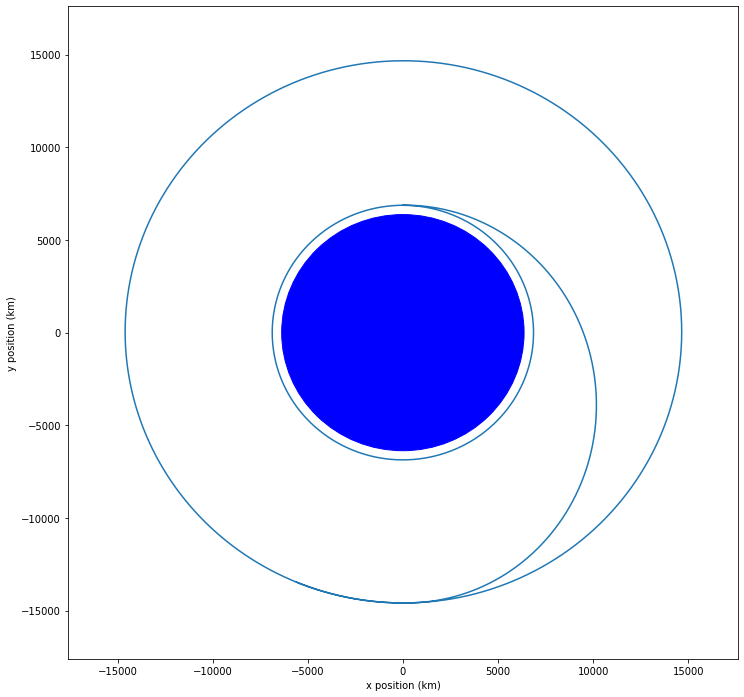

In [7]:

plt.figure(figsize=(12, 12))

x_positions = positions[:, 0]
y_positions = positions[:, 1]
plt.plot(x_positions, y_positions)

plt.xlabel("x position (km)")
plt.ylabel("y position (km)")

# Some gibberish that draws a big blue circle representing the Earth:
earth = plt.Circle((0, 0), radius_of_earth, color='b')
plt.gcf().gca().add_artist(earth)

# Make the plot big enough to show the original and final orbits:
plot_limit = 8000
plt.xlim(-2.2 * plot_limit, 2.2 * plot_limit)
plt.ylim(-2.2 * plot_limit, 2.2 * plot_limit)

plt.show()

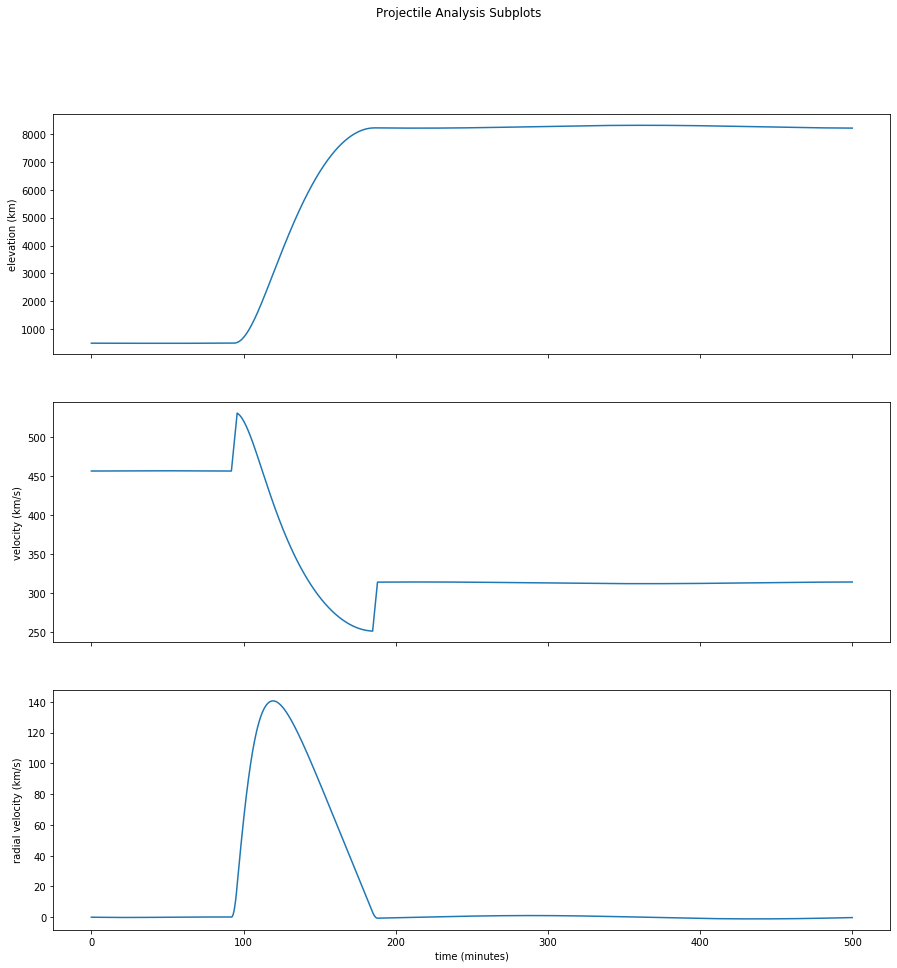

In [8]:
df = pd.DataFrame({
    'time' : times[:],
    'x_pos' : positions[:, 0],
    'y_pos' : positions[:, 1],
    'x_vel' : velocities[:, 0],
    'y_vel' : velocities[:, 1]
})
df['r_pos'] = (df.x_pos**2 + df.y_pos**2)**(1/2)
df['elevation'] = df.r_pos - radius_of_earth
df['velocity'] = (df.x_vel**2 + df.y_vel**2)**(1/2)
df['xs_pos'] = df.x_pos / df.r_pos
df['ys_pos'] = df.y_pos / df.r_pos
df['radial_vel'] = df.x_vel*df.xs_pos + df.y_vel*df.ys_pos
df['tangential_vel'] = df.x_vel*df.ys_pos - df.y_vel*df.xs_pos


fig, axs = plt.subplots(3,figsize=(15,15),sharex=True)
fig.suptitle('Projectile Analysis Subplots')

axs[0].set_ylabel('elevation (km)')
axs[0].plot(df.time, df.elevation)

axs[1].set_ylabel('velocity (km/s)')
axs[1].plot(df.time, df.velocity)

axs[2].set_ylabel('radial velocity (km/s)')
axs[2].set_xlabel('time (minutes)')
dummy = axs[2].plot(df.time, df.radial_vel)



# Example of how to create a new data-frame from an existing one.
#
# df1 = df[ df.elevation > 0 ]
#

## Playing with the Simulation and Checkout Questions

Look at arc VF in [the diagram Newton made](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Newton%27s_Principia_%281846%29.djvu/page519-1024px-Newton%27s_Principia_%281846%29.djvu.jpg). For that arc the cannonball goes about 20% of the way around the Earth.

Play with `initial_speed` in the initialization cell. Each time you change it, re-execute the entire notebook.

A good range of values to try is 3000 to 8000 m/s. What makes an arc that is most like Newton's arc VF?

Show me or Ben that you can set a breakpoint in your `strength_of_gravity` function and inspect what is happening.